In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import glob
import contextlib
from PIL import Image
plt.rcParams['figure.dpi'] = 300

2024-02-18 11:13:27.582440: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 11:13:27.659235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 11:13:27.659327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 11:13:27.662382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 11:13:27.676018: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 11:13:27.677387: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Model

In [2]:
class CVAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, num_classes,  kernel_size = 3):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim + num_classes,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="same"),
        ]
    )

  def call(self, inputs):
    image, temp = inputs
    mean, logvar = self.encode(image)
    z = self.reparameterize(mean, logvar)
    z = tf.concat([z, temp], axis=1)
    reconstructed = self.decode(z)
    return reconstructed

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  image, temp = x
  mean, logvar = model.encode(image)
  z = model.reparameterize(mean, logvar)
  z_t = tf.concat([z, temp], axis=1)
  x_logit = model.decode(z_t)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=image)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Sampling

In [3]:
def sample(num_examples_to_generate, model, temp_vector, latent_dim = 200):
    random_mean = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    z_t = tf.concat([z, temp_vector], axis=1)
    predictions = model.sample(z_t)
    return predictions

def load_model(path, latent_dim = 200, num_classes = 10):
    model = CVAE(latent_dim, num_classes)
    img = tf.zeros((1, 32, 32, 1))
    temp = tf.zeros((1, num_classes))
    dummy_input = (img, temp)
    model(dummy_input)
    model.load_weights(path)
    return model

In [4]:
temps = [t for t in np.arange(2.0, 3.1, 0.1)]
model = load_model("models/cvae.h5", 200, len(temps))

Text(0.5, 0.98, 'Ising configurations generated by different VAE models')

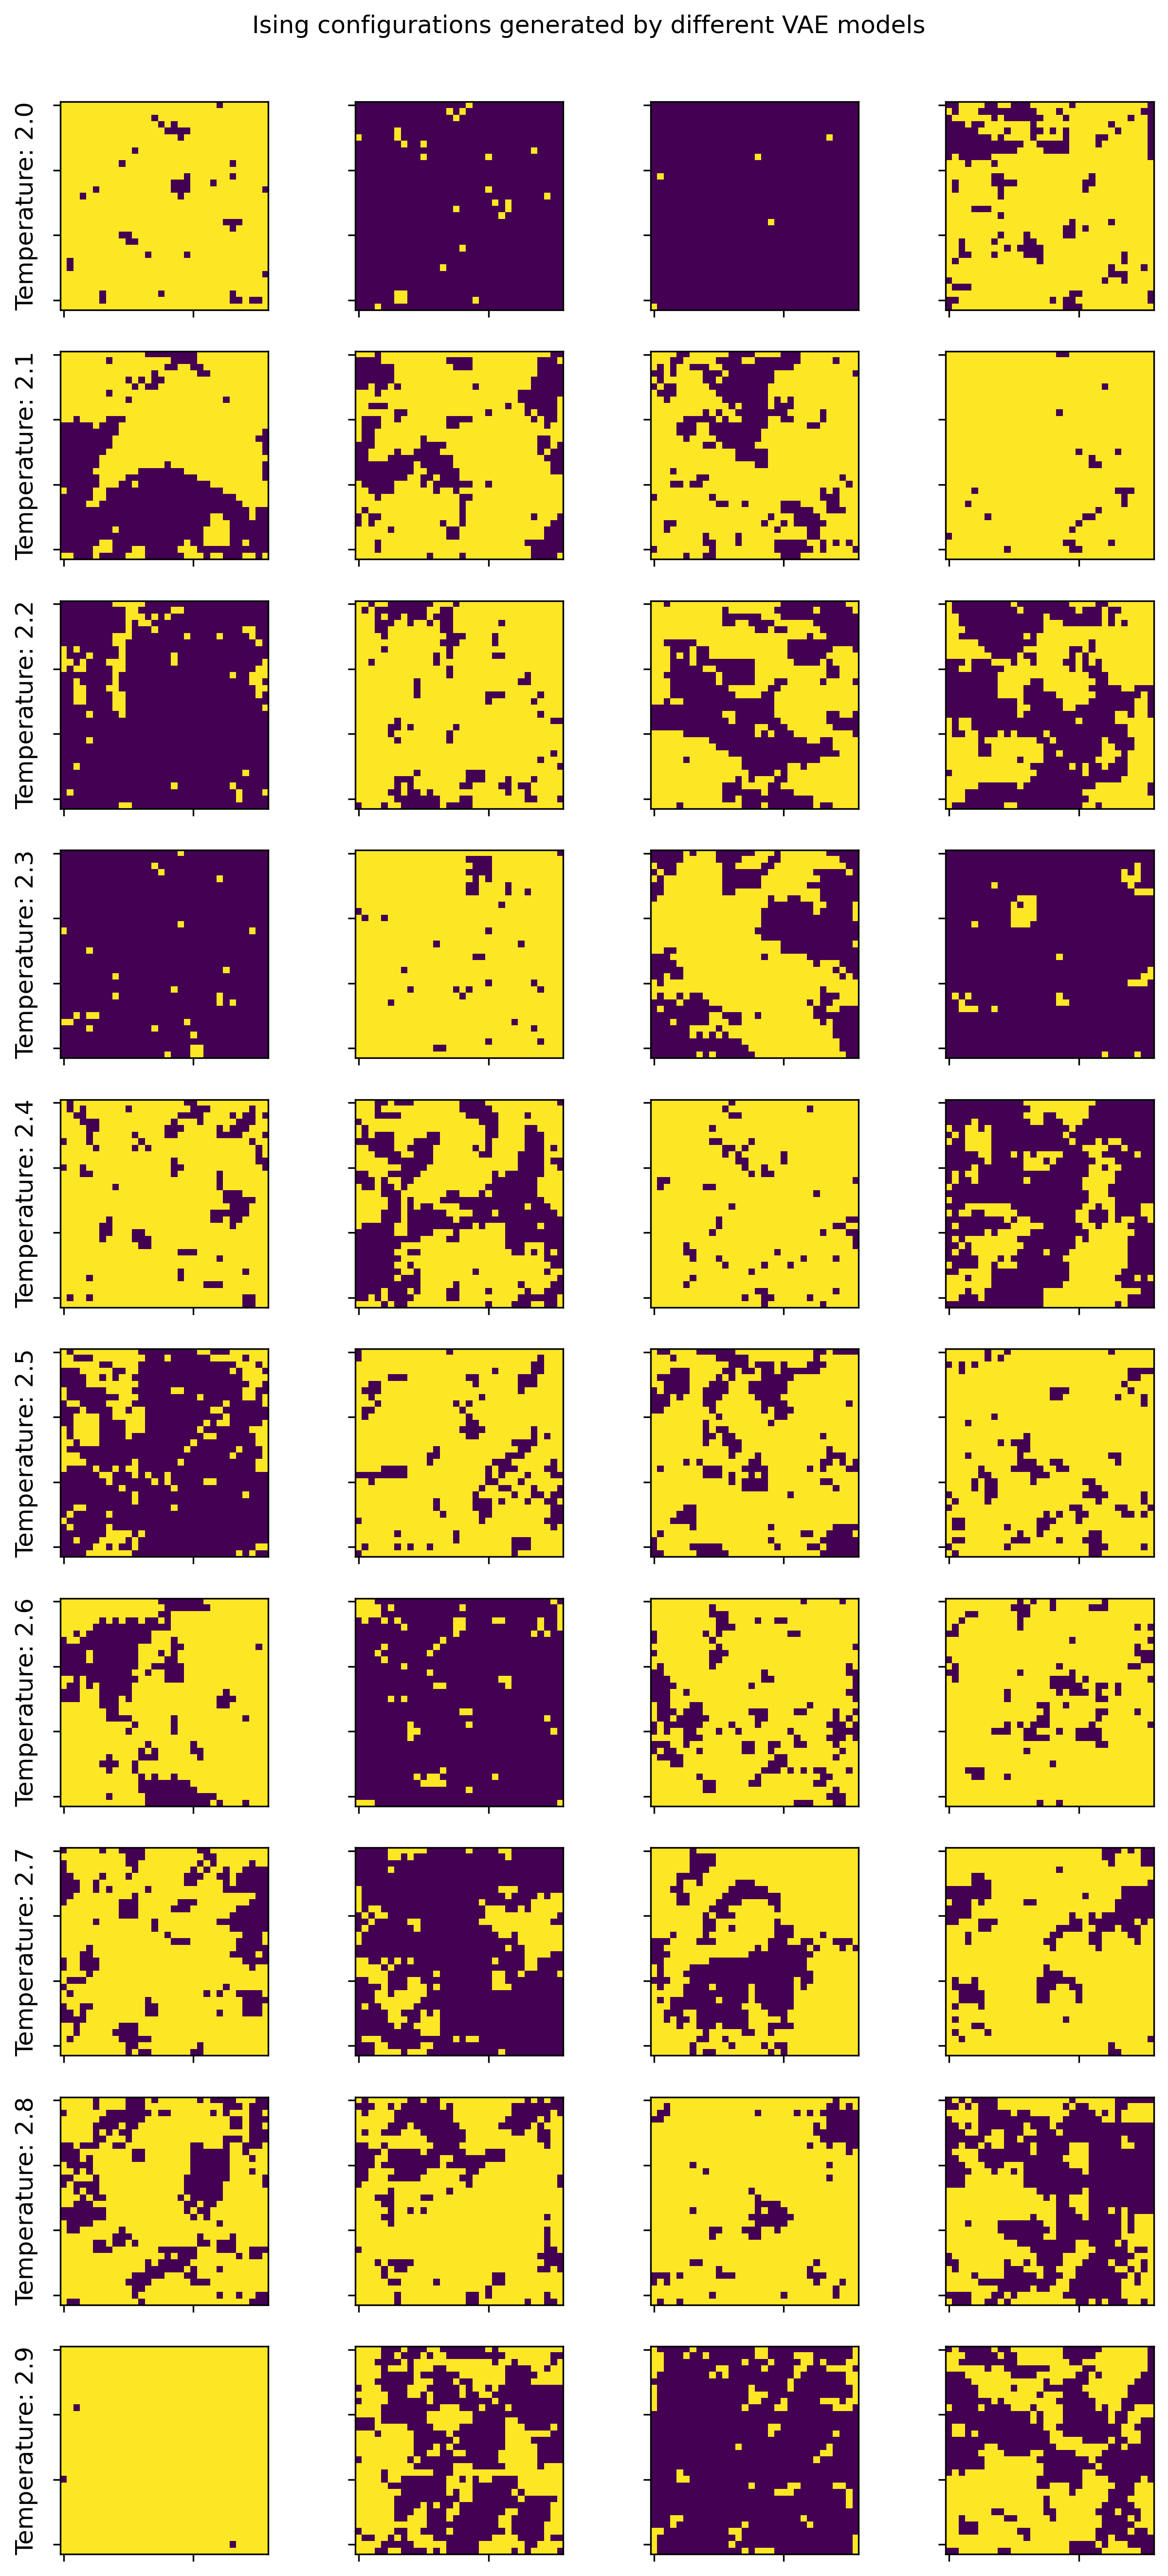

In [5]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 20))
titles = [f"Temperature: {t:.2}" for t in temps]

plt.subplots_adjust(top=0.95)  # Add space at the top

for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(titles[i], rotation=90, size='large')
    temp_vector = np.zeros((5, len(temps)))
    temp_vector[:, i] = 1
    predictions = sample(5, model, temp_vector)
    for j, ax in enumerate(ax_row):
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[j, :, :])
        ax.imshow(spins, vmin=0, vmax=1)

plt.suptitle("Ising configurations generated by different VAE models")


In [6]:
import sys
sys.path.append('..')
sys.path.append('../../GetData')
from macro import calcMag, calcEnergy
import input_pipeline

In [7]:
def get_df(data):
    df = pd.DataFrame({'image': list(data)})
    df['Magnetization'] = df['image'].apply(calcMag) / 32 ** 2
    df['Energy'] = df['image'].apply(calcEnergy)
    df.drop(columns='image', inplace=True)
    return df

def get_heat_capacity(df, t):
    return (1 / t )** 2 * df['Energy'].var()
    
def get_magnetic_susceptibility(df, t):
    return df['Magnetization'].var() / t

def get_stats(df, t):
    return [df['Magnetization'].abs().mean(), df['Energy'].mean(), get_magnetic_susceptibility(df, t), get_heat_capacity(df, t)]


data_list = []
for i, temp in enumerate(temps):
    # Monte Carlo
    trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
    batch_size = 10000
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    data_mc = next(iter(train_set))
    data_mc = 2 * data_mc - 1
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))

    # Sampled from CVAE
    temp_vector = np.zeros((100, len(temps)))
    temp_vector[:, i] = 1
    sample_data = []
    for _ in range(100):
        sample_data.append(sample(100, model, temp_vector))
    spin_sample = tf.concat(sample_data, axis = 0)
    spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
    df_sampled = get_df(spin_sample)
    sample_stats = get_stats(df_sampled, temp)
    sample_stats.extend((temp, "Sampled CVAE"))

    data_list.append(mc_stats)
    data_list.append(sample_stats)

TypeError: get_stats() missing 1 required positional argument: 't'

In [ ]:
df = pd.DataFrame(data_list, columns=['Magnetization', 'Energy', 'Magnetization Variance', 'Energy Variance', 'Temperature', 'Method'])
df.set_index(keys='Temperature', inplace=True)

In [ ]:
plt.figure(figsize=(15, 10))
plt.suptitle("Comparison of Monte Carlo and CVAE's latent space sampled data")
plt.subplots_adjust(top=0.92)
for i, column in enumerate(['Magnetization', 'Energy', 'Magnetization Variance', 'Energy Variance']):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=df, x=df.index, y=column, hue = 'Method', style='Method', markers=['o', 's'], alpha=0.5)